<a href="https://colab.research.google.com/github/maximum4645/MobileNetV2-for-Waste-Classification/blob/main/training_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

In [2]:
!pip install onnx onnx-tf
!pip install numpy==1.26.4 --force-reinstall
!pip install tensorflow==2.15.0
!pip install tensorflow-probability==0.23.0

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.15.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
jax 0.5.2 requires ml_dtypes>=0.4.0, but you have ml-dtypes 0.2.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, b

In [3]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms.functional import adjust_sharpness
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
# Define data directory
data_dir = '/content/drive/MyDrive/Colab Notebooks/Waste Classification/Data/selected_data'

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Lambda(lambda img: adjust_sharpness(img, sharpness_factor=2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset using ImageFolder
dataset = ImageFolder(root=data_dir)

# Split into training and testing datasets
train_idx, test_idx = train_test_split(
    list(range(len(dataset.targets))), test_size=0.2, stratify=dataset.targets
)

train_set = torch.utils.data.Subset(dataset, train_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

# Apply transformations
train_set.dataset.transform = train_transform
test_set.dataset.transform = test_transform

# DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Print class names and dataset sizes
classes = dataset.classes
print("Classes:", classes)
print(f"Train dataset size: {len(train_set)}")
print(f"Test dataset size: {len(test_set)}")


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Train dataset size: 1457
Test dataset size: 365


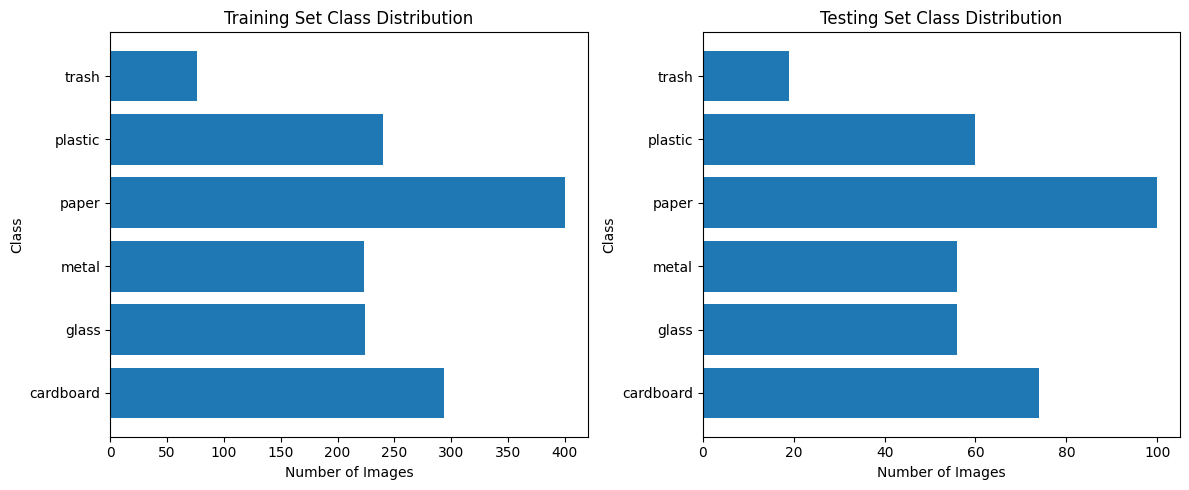

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

# Calculate class distributions
train_counter = Counter([dataset.targets[i] for i in train_idx])
test_counter = Counter([dataset.targets[i] for i in test_idx])

train_labels = list(train_counter.keys())
train_values = list(train_counter.values())

test_labels = list(test_counter.keys())
test_values = list(test_counter.values())

# Plot the distributions with horizontal bars
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
ax[0].barh(train_labels, train_values, tick_label=[classes[i] for i in train_labels])
ax[0].set_title("Training Set Class Distribution")
ax[0].set_ylabel("Class")
ax[0].set_xlabel("Number of Images")

# Testing set distribution
ax[1].barh(test_labels, test_values, tick_label=[classes[i] for i in test_labels])
ax[1].set_title("Testing Set Class Distribution")
ax[1].set_ylabel("Class")
ax[1].set_xlabel("Number of Images")

plt.tight_layout()
plt.show()

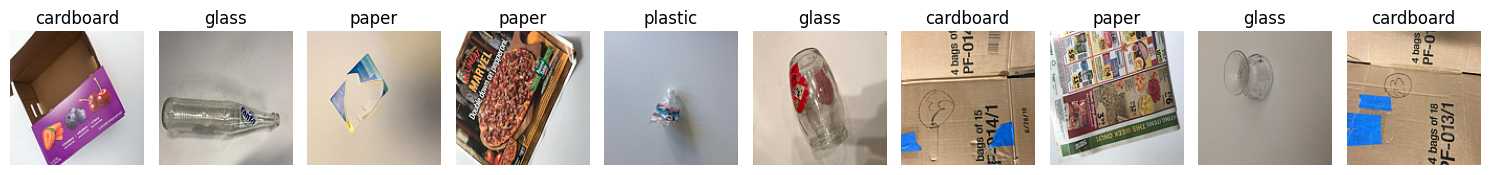

In [6]:
# Function to display images with labels
def imshow_with_labels(images, labels, classes):
    images = images / 2 + 0.5  # Unnormalize
    npimg = images.numpy()
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(npimg[i], (1, 2, 0)))
        ax.set_title(classes[labels[i].item()])  # Convert tensor to index and map to English
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first n images with labels
n = 10  # Display fewer images for readability
imshow_with_labels(images[:n], labels[:n], classes)

# Model

In [7]:
from torchvision.models import mobilenet_v2
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(dataset.classes)

# Define MobileNet_v2
mobilenet_v2_model = mobilenet_v2(pretrained=True)
for param in mobilenet_v2_model.features.parameters():
    param.requires_grad = False  # Freeze all layers in the features section
# Unfreeze the last two inverted residual blocks
for param in mobilenet_v2_model.features[-12:].parameters():  # Adjusted for two blocks
    param.requires_grad = True
# Modify the classifier for 6 classes
mobilenet_v2_model.classifier[1] = nn.Linear(mobilenet_v2_model.last_channel, num_classes)
mobilenet_v2_model.classifier[1].requires_grad = True
mobilenet_v2_model = mobilenet_v2_model.to(device)

print(mobilenet_v2_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 134MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Pre-Test


MobileNet_v2 Metrics:
Accuracy: 13.70%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.40      0.08      0.13        74
       glass       0.20      0.02      0.03        56
       metal       0.26      0.29      0.27        56
       paper       0.00      0.00      0.00       100
     plastic       0.21      0.32      0.26        60
       trash       0.04      0.42      0.08        19

    accuracy                           0.14       365
   macro avg       0.19      0.19      0.13       365
weighted avg       0.19      0.14      0.12       365



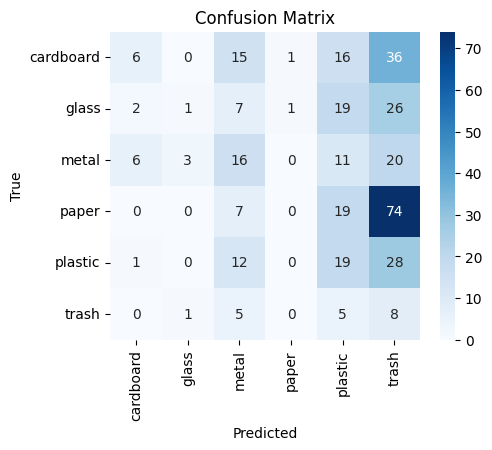

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to calculate detailed metrics
def evaluate_model(model, data_loader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=classes, digits=2)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy, report, cm

# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_before, mobilenet_v2_report_before, mobilenet_v2_cm_before = evaluate_model(mobilenet_v2_model, test_loader, device, classes)


# Training

In [9]:
import torch.optim as optim
from torch.utils.data import random_split
from collections import Counter
import random
from torchvision.transforms import functional as TF

# ================== Define the Training Function ==================
def train_model(model, train_loader, val_loader=None, criterion=None, optimizer=None, device=None, epochs=30, patience=10):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf') if val_loader else None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss = val_loss / len(val_loader)
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}")

    return train_losses, val_losses if val_loader else train_losses

# ================== Split the Training Data ==================
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_idx, val_idx = random_split(range(len(train_set)), [train_size, val_size])

train_subset = torch.utils.data.Subset(train_set, train_idx)
val_subset   = torch.utils.data.Subset(train_set, val_idx)

# ================== Class Balancing for Training Subset ==================
augmented_images = []
augmented_labels = []

# Count images per class from the subset
class_counts     = Counter(label for _, label in train_subset)
max_class_count  = max(class_counts.values())

# Augment underrepresented classes
for class_idx, count in class_counts.items():
    if count < max_class_count:
        diff = max_class_count - count
        print(f"Augmenting class {classes[class_idx]}: {count} -> {max_class_count}")

        # get all (img,label) pairs from the subset for this class
        class_items = [(img, lbl) for img, lbl in train_subset if lbl == class_idx]

        for _ in range(diff):
            img, lbl = random.choice(class_items)
            img = TF.rotate(img, angle=random.uniform(-15, 15))
            if random.random() > 0.5:
                img = TF.hflip(img)
            augmented_images.append(img)
            augmented_labels.append(lbl)

# Combine original and augmented data for the training subset
train_dataset = [(img, lbl) for img, lbl in train_subset]
train_dataset.extend(zip(augmented_images, augmented_labels))

# ================== Create DataLoaders ==================
train_loader_32 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_32   = torch.utils.data.DataLoader(val_subset,   batch_size=32, shuffle=False)

# ================== Define Common Training Settings ==================
criterion = torch.nn.CrossEntropyLoss()

# ================== Train MobileNet_v2 ==================
print("\nTraining MobileNet_v2...")
mobilenet_v2_optimizer = optim.SGD(
    mobilenet_v2_model.parameters(),
    lr=0.003236,
    momentum=0.643430
)
mobilenet_v2_train_losses, mobilenet_v2_val_losses = train_model(
    mobilenet_v2_model,
    train_loader_32,
    val_loader_32,
    criterion,
    mobilenet_v2_optimizer,
    device
)


Augmenting class cardboard: 229 -> 330
Augmenting class glass: 184 -> 330
Augmenting class metal: 164 -> 330
Augmenting class plastic: 196 -> 330
Augmenting class trash: 62 -> 330

Training MobileNet_v2...
Epoch 1/30, Train Loss: 0.8586, Val Loss: 0.5713
Epoch 2/30, Train Loss: 0.2816, Val Loss: 0.4959
Epoch 3/30, Train Loss: 0.1415, Val Loss: 0.4555
Epoch 4/30, Train Loss: 0.0730, Val Loss: 0.4300
Epoch 5/30, Train Loss: 0.0495, Val Loss: 0.4477
Epoch 6/30, Train Loss: 0.0339, Val Loss: 0.4547
Epoch 7/30, Train Loss: 0.0267, Val Loss: 0.4287
Epoch 8/30, Train Loss: 0.0243, Val Loss: 0.4192
Epoch 9/30, Train Loss: 0.0141, Val Loss: 0.4666
Epoch 10/30, Train Loss: 0.0160, Val Loss: 0.4500
Epoch 11/30, Train Loss: 0.0173, Val Loss: 0.4141
Epoch 12/30, Train Loss: 0.0124, Val Loss: 0.4254
Epoch 13/30, Train Loss: 0.0160, Val Loss: 0.4500
Epoch 14/30, Train Loss: 0.0084, Val Loss: 0.4415
Epoch 15/30, Train Loss: 0.0075, Val Loss: 0.4727
Epoch 16/30, Train Loss: 0.0086, Val Loss: 0.4710
Epo

# Post-Test


MobileNet_v2 Metrics:
Accuracy: 93.42%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.99      0.96      0.97        74
       glass       0.88      0.91      0.89        56
       metal       0.94      0.86      0.90        56
       paper       0.94      0.98      0.96       100
     plastic       0.94      0.97      0.95        60
       trash       0.83      0.79      0.81        19

    accuracy                           0.93       365
   macro avg       0.92      0.91      0.91       365
weighted avg       0.93      0.93      0.93       365



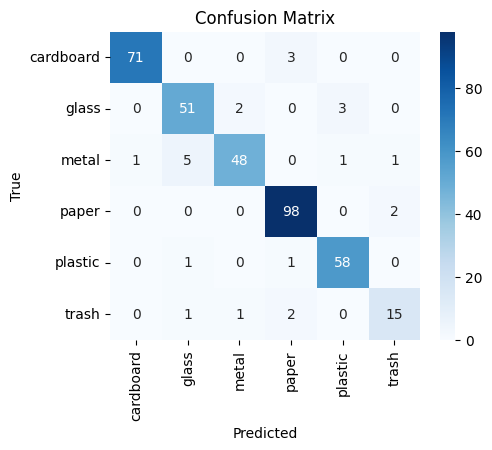

In [10]:
# Evaluate MobileNet_v2
print("\nMobileNet_v2 Metrics:")
mobilenet_v2_accuracy_after, mobilenet_v2_report_after, mobilenet_v2_cm_after = evaluate_model(mobilenet_v2_model, test_loader, device, classes)

In [11]:
# Accuracy Comparison
print(f"  Before Training Accuracy: {mobilenet_v2_accuracy_before:.2f}%")
print(f"  After Training Accuracy: {mobilenet_v2_accuracy_after:.2f}%")

  Before Training Accuracy: 13.70%
  After Training Accuracy: 93.42%


# Misclassification

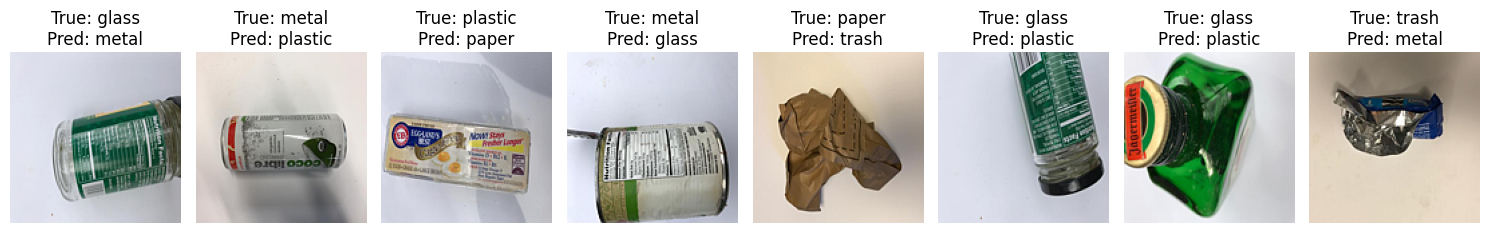

In [12]:
def visualize_misclassifications(model, data_loader, device, classes, num_images=8):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))
                    if len(misclassified) >= num_images:
                        break
            if len(misclassified) >= num_images:
                break

    # Handle case with fewer misclassifications
    num_to_plot = min(len(misclassified), num_images)

    # Plot misclassified images
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 5))
    if num_to_plot == 1:
        axes = [axes]  # Handle single subplot case
    for ax, (img, true_label, pred_label) in zip(axes, misclassified):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_misclassifications(mobilenet_v2_model, test_loader, device, classes, num_images=8)


# Model Saving

## Model Size

In [13]:
def get_model_size(model):
    # Calculate the size of the model in MB
    param_size = sum(p.numel() for p in model.parameters()) * 4  # 4 bytes for each float32
    buffer_size = sum(p.numel() for p in model.buffers()) * 4    # 4 bytes for each float32
    total_size = param_size + buffer_size
    return total_size / (1024 * 1024)  # Convert to MB

model_size = get_model_size(mobilenet_v2_model)
print(f"MobileNet_v2 Model Size: {model_size:.2f} MB")

MobileNet_v2 Model Size: 8.64 MB


## Export as .pth

In [14]:
# Define the path to the Models folder
folder_path = '/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/PyTorch'

# Create the Models folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created (or already exists) at: {folder_path}")

# Save the trained models as .pth files
try:

    # Save MobileNet_v2 model
    mobilenet_v2_path = os.path.join(folder_path, "model_1.pth")
    torch.save(mobilenet_v2_model.state_dict(), mobilenet_v2_path)
    print(f"MobileNet_v2 model saved at: {mobilenet_v2_path}")

except NameError:
    print("Error: Ensure your model is defined.")

Folder created (or already exists) at: /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/PyTorch
MobileNet_v2 model saved at: /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/PyTorch/model_1.pth


## Export as .onnx

In [15]:
# Define the ONNX directory in Google Drive
onnx_dir = "/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/ONNX"
os.makedirs(onnx_dir, exist_ok=True)
print(f"ONNX models will be saved in: {onnx_dir}")

# Define function to export a PyTorch model to ONNX
def export_to_onnx(model, model_name, save_path, device):
    model = model.to(device)  # Ensure model is on the correct device
    model.eval()
    dummy_input = torch.randn(1, 3, 128, 128).to(device)  # Match input tensor to model's device
    torch.onnx.export(
        model,
        dummy_input,
        save_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"]
    )
    print(f"{model_name} exported to ONNX format at: {save_path}")

# Ensure device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Export each model using their respective variables
export_to_onnx(mobilenet_v2_model, "model_1", os.path.join(onnx_dir, "model_1.onnx"), device)

ONNX models will be saved in: /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/ONNX
model_1 exported to ONNX format at: /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/ONNX/model_1.onnx


# Model Conversion

## PyTorch to ONNX

In [16]:
# import os
# import torch
# import torch.nn as nn
# import torchvision.models as models

# # Define directories in Google Drive
# pth_dir  = "/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/PyTorch"
# onnx_dir = "/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/ONNX"
# os.makedirs(onnx_dir, exist_ok=True)
# print(f".pth models will be loaded from: {pth_dir}")
# print(f".onnx models will be saved in: {onnx_dir}")

# # Export function (unchanged)
# def export_to_onnx(model, model_name, save_path, device, input_shape=(1,3,128,128)):
#     model = model.to(device)
#     model.eval()
#     dummy_input = torch.randn(*input_shape).to(device)
#     torch.onnx.export(
#         model,
#         dummy_input,
#         save_path,
#         export_params=True,
#         opset_version=11,
#         do_constant_folding=True,
#         input_names=["input"],
#         output_names=["output"]
#     )
#     print(f"{model_name} exported to ONNX format at: {save_path}")


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_classes = 6

# # Load and adjust MobileNet_v2 for your number of classes
# mobilenet_v2_path = os.path.join(pth_dir, "model_1.pth")
# mobilenet_v2_model = models.mobilenet_v2(pretrained=False)

# # Replace the classifier to match the checkpoint’s output size
# in_features = mobilenet_v2_model.classifier[1].in_features
# mobilenet_v2_model.classifier[1] = nn.Linear(in_features, num_classes)

# # Load your checkpoint
# mobilenet_v2_model.load_state_dict(
#     torch.load(mobilenet_v2_path, map_location=device)
# )

# # Export to ONNX
# export_to_onnx(
#     mobilenet_v2_model,
#     "model_1",
#     os.path.join(onnx_dir, "model_1.onnx"),
#     device,
#     input_shape=(1, 3, 128, 128)
# )


## ONNX to TensorFlow

In [17]:
import tensorflow as tf
import numpy as np
from tensorflow_probability import distributions as tfd

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability loaded successfully!")

TensorFlow version: 2.15.0
NumPy version: 1.26.4
TensorFlow version: 2.15.0
TensorFlow Probability loaded successfully!


In [18]:
from onnx_tf.backend import prepare
import onnx
import os

# Define the directory for ONNX and TensorFlow models
onnx_dir     = "/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/ONNX"
tf_model_dir = "/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TensorFlow"
os.makedirs(tf_model_dir, exist_ok=True)

print(f"ONNX model is located in: {onnx_dir}")
print(f"TensorFlow model will be saved in: {tf_model_dir}")

# Only convert MobileNet_v2 since that's the model you have
onnx_saved_model_pairs = [
    (
        os.path.join(onnx_dir, "model_1.onnx"),
        os.path.join(tf_model_dir, "model_1.saved_model")
    )
]

# Convert ONNX model to TensorFlow SavedModel
for onnx_path, saved_model_path in onnx_saved_model_pairs:
    try:
        onnx_model = onnx.load(onnx_path)
        tf_rep     = prepare(onnx_model)
        tf_rep.export_graph(saved_model_path)
        print(f"Successfully converted {onnx_path} to {saved_model_path}")
    except Exception as e:
        print(f"Error converting {onnx_path} to {saved_model_path}: {e}")


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


ONNX model is located in: /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/ONNX
TensorFlow model will be saved in: /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TensorFlow
Successfully converted /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/ONNX/model_1.onnx to /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TensorFlow/model_1.saved_model


TensorFlow to TFLite

In [19]:
import os
import tensorflow as tf

# Define directories for TensorFlow SavedModels and TFLite models
tf_model_dir      = "/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TensorFlow"
tflite_model_dir  = "/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TFLite"
os.makedirs(tflite_model_dir, exist_ok=True)

print(f"TensorFlow SavedModels are located in: {tf_model_dir}")
print(f"TFLite models will be saved in: {tflite_model_dir}")

# Only convert the MobileNet_v2 SavedModel
saved_model_tflite_pairs = [
    (
        os.path.join(tf_model_dir, "model_1.saved_model"),
        os.path.join(tflite_model_dir, "model_1.tflite")
    )
]

# Convert TensorFlow SavedModel to TFLite
for saved_model_path, tflite_path in saved_model_tflite_pairs:
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()

        with open(tflite_path, "wb") as f:
            f.write(tflite_model)
        print(f"Successfully converted {saved_model_path} to {tflite_path}")
    except Exception as e:
        print(f"Error converting {saved_model_path} to {tflite_path}: {e}")

# Verify input and output details for the MobileNet_v2 TFLite model
for _, tflite_path in saved_model_tflite_pairs:
    try:
        interpreter = tf.lite.Interpreter(model_path=tflite_path)
        interpreter.allocate_tensors()

        input_details  = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        print(f"Model: {tflite_path}")
        print("  Input Data Type:", input_details[0]['dtype'])
        print("  Output Data Type:", output_details[0]['dtype'])
    except Exception as e:
        print(f"Error inspecting {tflite_path}: {e}")


TensorFlow SavedModels are located in: /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TensorFlow
TFLite models will be saved in: /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TFLite
Successfully converted /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TensorFlow/model_1.saved_model to /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TFLite/model_1.tflite
Model: /content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TFLite/model_1.tflite
  Input Data Type: <class 'numpy.float32'>
  Output Data Type: <class 'numpy.float32'>


## Testing


Evaluating MobileNet_v2 TFLite Model:
Accuracy: 92.60%
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.96      0.96      0.96        74
       glass       0.86      0.91      0.89        56
       metal       0.94      0.82      0.88        56
       paper       0.94      0.98      0.96       100
     plastic       0.94      0.97      0.95        60
       trash       0.82      0.74      0.78        19

    accuracy                           0.93       365
   macro avg       0.91      0.90      0.90       365
weighted avg       0.93      0.93      0.93       365



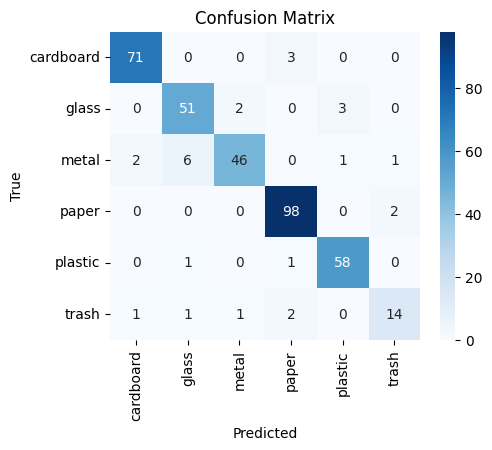

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_tflite_model(tflite_model_path, test_loader, classes):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    all_preds = []
    all_labels = []

    # Iterate through the test dataset
    for images, labels in test_loader:
        images = images.numpy()
        labels = labels.numpy()

        for i in range(len(images)):
            # Preprocess the image for TFLite input
            input_data = np.expand_dims(images[i], axis=0).astype(np.float32)

            # Set the input tensor
            interpreter.set_tensor(input_details[0]['index'], input_data)

            # Run inference
            interpreter.invoke()

            # Get the output tensor
            output_data = interpreter.get_tensor(output_details[0]['index'])
            pred = np.argmax(output_data)

            # Collect predictions and labels
            all_preds.append(pred)
            all_labels.append(labels[i])

    # Calculate accuracy
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=classes, digits=2)
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate TFLite model

print("\nEvaluating MobileNet_v2 TFLite Model:")
evaluate_tflite_model("/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TFLite/model_1.tflite", test_loader, classes)


## Model Size

In [21]:
import os
import time
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import tensorflow as tf

def get_file_size_in_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# def measure_pytorch_inference(pth_path, num_classes=6, input_shape=(1,3,128,128), runs=50, warmup_runs=5):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = models.mobilenet_v2(pretrained=False)
#     in_features = model.classifier[1].in_features
#     model.classifier[1] = nn.Linear(in_features, num_classes)
#     model.load_state_dict(torch.load(pth_path, map_location=device))
#     model.to(device).eval()

#     inp = torch.randn(*input_shape).to(device)
#     for _ in range(warmup_runs):
#         _ = model(inp)

#     start = time.time()
#     for _ in range(runs):
#         _ = model(inp)
#     return (time.time() - start) / runs

# def measure_tflite_inference(tflite_path, input_shape=(1,128,128,3), runs=50, warmup_runs=5):
#     interpreter = tf.lite.Interpreter(model_path=tflite_path)
#     interpreter.allocate_tensors()
#     input_details = interpreter.get_input_details()

#     inp = np.random.rand(*input_shape).astype(np.float32)
#     interpreter.set_tensor(input_details[0]['index'], inp)
#     for _ in range(warmup_runs):
#         interpreter.invoke()

#     start = time.time()
#     for _ in range(runs):
#         interpreter.set_tensor(input_details[0]['index'], inp)
#         interpreter.invoke()
#     return (time.time() - start) / runs

# Paths to your model files
pth_path    = "/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/PyTorch/model_1.pth"
tflite_path = "/content/drive/MyDrive/Colab Notebooks/Waste Classification/Models/TFLite/model_1.tflite"

# Compute file sizes
pth_size    = get_file_size_in_mb(pth_path)
tflite_size = get_file_size_in_mb(tflite_path)

# # Measure inference times
# pt_time     = measure_pytorch_inference(pth_path)
# tf_time     = measure_tflite_inference(tflite_path)

# Display comparison
print(f"{'Model':<12}{'PTH Size (MB)':>15}{'TFLite Size (MB)':>18}")
print(f"{'mobilenet':<12}{pth_size:>15.2f}{tflite_size:>18.2f}")


Model         PTH Size (MB)  TFLite Size (MB)
mobilenet              8.75              2.39
